In [1]:
#timesformer model

import os.path as osp
import pickle
import shutil
import tempfile

import mmcv
import torch
import torch.distributed as dist
from mmcv.runner import get_dist_info
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.fileio.io import file_handlers
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from mmcv.runner.fp16_utils import wrap_fp16_model

#from mmaction.apis import multi_gpu_test, single_gpu_test
from mmaction.apis import multi_gpu_test 
from mmaction.datasets import build_dataloader, build_dataset
from mmaction.models import build_model
from mmaction.utils import register_module_hooks
import time
from tqdm import tqdm
from itertools import combinations
from mmaction.models.recognizers import GumbelSampler2DRecognizer2D, Sampler2DRecognizer2D, Sampler2DRecognizer3D
from mmaction.models.backbones import MobileNetV2TSM, ResNet, MobileNetV2
from mmaction.models.backbones.mobilenet_v2 import InvertedResidual
from mmaction.models.heads import TSMHead
from mmaction.models import build_model
from mmaction.datasets import build_dataset, build_dataloader
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
import torch
from tqdm import tqdm
from mmaction.core.evaluation.accuracy import top_k_accuracy, mean_average_precision
from einops import rearrange



# config = "configs/anet_timesformer_uniform10.py"
# checkpoint = "modelzoo/timesformer_6x100x1_anet.pth"

config = "configs/minik_timesformer_uniform10.py"
checkpoint = "modelzoo/timesformer_6x43x1_minik.pth"

# config = "configs/single_anet_timesformer_6x100x1.py"
# checkpoint = "modelzoo/timesformer_6x100x1_anet.pth"

cfg = Config.fromfile(config)

dataset = build_dataset(cfg.data.test, dict(test_mode=True))
# dataset = build_dataset(cfg.data.train, dict(test_mode=True))
dataloader_setting = dict(
    videos_per_gpu=cfg.data.get('videos_per_gpu', 1),
    workers_per_gpu=cfg.data.get('workers_per_gpu', 1),
    dist=False,
    shuffle=False)
dataloader_setting = dict(dataloader_setting,
                            **cfg.data.get('test_dataloader', {}))
data_loader = build_dataloader(dataset, **dataloader_setting)

model = build_model(
        cfg.model, train_cfg=None, test_cfg=cfg.get('test_cfg'))
load_checkpoint(model, checkpoint, map_location='cpu')
model = model.cuda()

load checkpoint from local path: modelzoo/timesformer_6x43x1_minik.pth


In [2]:
def single_gpu_test(model, data_loader, mode='score1frame'):
    """Test model with a single gpu.

    This method tests model with a single gpu and displays test progress bar.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (nn.Dataloader): Pytorch data loader.

    Returns:
        list: The prediction results.
    """
    print("############################################################")
    results = []
    sampled_indice = []
    rconfs = []
    wconfs = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))  
    start = time.time()
    total_seg = 10
    perm_num = 6
    perms = torch.tensor(list(combinations([i for i in range(total_seg)],perm_num)))
    softmax = True
    for data in data_loader:
        end = time.time()
        # print(f"Get data {end - start:.5f} sec")
        model.eval()
        with torch.no_grad():
            imgs, labels = data['imgs'], data['label'].squeeze()
            imgs, labels = imgs.cuda(), labels.cuda()
            # print(f"labels = {labels}")           

            if mode == 'two':
                B, T, C, H, W = imgs.shape
                imgs = imgs.reshape(B*T, C, H, W)
                feats = model.extract_feat(imgs)
                logits = model.cls_head(feats, 1)
                logits = logits.reshape(B, T, -1)
                # print(f"labels = {labels}")
                label_logits = logits[range(B), :, labels.squeeze()]
                max_idx = label_logits.max(-1)[1]
                logits = logits[range(B), max_idx]
                result = logits.detach().cpu().numpy()

                # for i in range(num_segs):
                #     logits = model.cls_head(feats[i:i+1], 1)
                #     if logits.softmax(-1)[:,labels.bool()] > result:
                #         result = logits

                    # print(result)
            elif mode == 'original':
                B, N, C, T, H, W = imgs.shape
                imgs = imgs.reshape(B, C, T, H, W)
                x = model.extract_feat(imgs)
                logits = model.cls_head(x)
                result = logits.detach().cpu().numpy()
            elif mode == 'bruteforce':
                B, N, C, T, H, W = imgs.shape
                imgs = rearrange(imgs, 'b n c t h w -> (b n) c t h w')
                perm_logits = []
                score = torch.zeros([B, total_seg]).cuda()
                # best = torch.ones([B]).cuda() * -100
                for perm in perms:
                    indice = torch.tensor([1 if i in perm else 0 for i in range(total_seg)]).bool()
                    x = model.cls_head(model.extract_feat(imgs[:,:,indice]))
                    if softmax:
                        x = x.softmax(-1)
                    perm_logits.append(x) # B num_classes
                perm_logits = torch.stack(perm_logits, 1) # B len(perms) C
                label_logits = perm_logits[range(B), :, labels.squeeze()]
                max_idx = label_logits.max(-1)[1]
                sampled_indice.extend(perms[max_idx].detach().cpu().numpy())
                result = perm_logits[range(B), max_idx, :]
                result = result.detach().cpu().numpy()
            elif mode == 'score2frame':
                B, N, C, T, H, W = imgs.shape
                perm_imgs = []
                score = torch.zeros([B, total_seg]).cuda()
                for perm in perms:
                    indice = torch.tensor([1 if i in perm else 0 for i in range(total_seg)]).bool()
                    perm_imgs.append(imgs[:,:,:,indice])
                perm_imgs = torch.stack(perm_imgs, 1)
                perm_imgs = rearrange(perm_imgs, 'b p n c t h w -> (b p n) c t h w')
                x = model.extract_feat(perm_imgs)
                logits = model.cls_head(x) # B*len(perms) num_classes
                if softmax:
                    logits = logits.softmax(-1)
                logits = rearrange(logits, '(b p) n -> b p n', b = B, p = len(perms)) # B len(perms) num_classes
                label_logits = logits[range(B), :, labels.squeeze()]
                # for i in range(len(perms)):
                #     for j in range(len(perms[i])):
                #         score[:, perms[i][j]] += label_logits[:, i]
                total_score = label_logits.sum(-1)
                tmp = torch.zeros_like(total_score)
                for i in range(total_seg):
                    for j in range(len(perms)):
                        if i in perms[j]:
                            tmp += label_logits[:, j]
                    score[:, i] = total_score - tmp
                max_idx = score.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
                batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
                imgs = rearrange(imgs, 'b n c t h w -> (b n) t c h w')
                sampled_imgs = imgs[batch_inds, max_idx]
                sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')
                fx = model.extract_feat(sampled_imgs)
                flogits = model.cls_head(fx)
                result = flogits.detach().cpu().numpy()
            elif mode == 'score1frame':
                B, N, C, T, H, W = imgs.shape
                imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
                # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
                x = model.extract_feat(imgs.unsqueeze(2))
                logits = model.cls_head(x) # B*T num_classes
                if softmax:
                    logits = logits.softmax(-1)

                dlabels = labels.clone().unsqueeze(1).repeat(1,total_seg).flatten()
                y_hat = logits.argmax(-1)
                # rconf = logits[y_hat == dlabels]
                # wconf = logits[y_hat != dlabels]
                # rtmp = dlabels[y_hat == dlabels]
                # wtmp = dlabels[y_hat != dlabels]
                # rconfs.extend(rconf[range(rtmp.shape[0]),rtmp])
                # wconfs.extend(wconf[range(wtmp.shape[0]),wtmp])

                logits = logits.reshape(B, T, -1)                    
                label_logits = logits[range(B), :, labels.squeeze()]
                # rconfs.extend(label_logits)

                max_idx = label_logits.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
                # rconf, max_idx = label_logits.topk(6, dim=1)
                # max_idx = max_idx.sort(dim=1,descending=False)[0]
                # rconfs.extend(rconf)

                batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
                imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b=B, t=T)
                sampled_imgs = imgs[batch_inds, max_idx]
                sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')

                fx = model.extract_feat(sampled_imgs)
                flogits = model.cls_head(fx)
                result = flogits.detach().cpu().numpy()
                sampled_indice.extend(max_idx.detach().cpu().numpy())
                # max_idx = label_logits.max(-1)[1]
                # result = logits[range(B), max_idx, :]
                # result = result.detach().cpu().numpy()
            elif mode == 'entropy':
                B, N, C, T, H, W = imgs.shape
                imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
                # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
                x = model.extract_feat(imgs.unsqueeze(2))
                logits = model.cls_head(x) # B*T num_classes
                logits = logits.softmax(-1)
                negative_entropy = (logits * torch.log(logits)).sum(-1)
                negative_entropy = negative_entropy.reshape(B, T)
                max_idx = negative_entropy.topk(5, dim=1)[1].sort(dim=1,descending=False)[0]
                batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
                imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b=B, t=T)
                sampled_imgs = imgs[batch_inds, max_idx]
                sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')

                fx = model.extract_feat(sampled_imgs)
                flogits = model.cls_head(fx)
                result = flogits.detach().cpu().numpy()
            elif mode == 'max_confidence':
                B, N, C, T, H, W = imgs.shape
                imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
                # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
                x = model.extract_feat(imgs.unsqueeze(2))
                logits = model.cls_head(x) # B*T num_classes
                logits = logits.softmax(-1)
                argmax_indice = logits.argmax(-1)
                # print("argmax_indice = ", argmax_indice.shape)
                argmax_logits = logits[range(B*T), argmax_indice.squeeze()]
                # print("argmax_logits = ",argmax_logits.shape)
                argmax_logits = argmax_logits.reshape(B, T)
                # print("argmax_logits reshape = ",argmax_logits.shape)
                
                max_idx = argmax_logits.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
                # print("max_idx = ", max_idx)
                batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
                imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b=B, t=T)
                sampled_imgs = imgs[batch_inds, max_idx]
                sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')

                fx = model.extract_feat(sampled_imgs)
                flogits = model.cls_head(fx)
                result = flogits.detach().cpu().numpy()


        results.extend(result)
        # print(np.asarray(results).shape)
        # use the first key as main key to calculate the batch size
        batch_size = len(next(iter(data.values())))
        for _ in range(batch_size):
            prog_bar.update()
        start = time.time()
        # results = collect_results_gpu(results, len(dataset))
    return results, sampled_indice, rconfs, wconfs

In [16]:
results, sampled_indice, rconfs, wconfs = single_gpu_test(model, data_loader, mode='score1frame')

############################################################
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 9858/9858, 12.9 task/s, elapsed: 763s, ETA:     0s

In [48]:
import numpy as np
sampled_indice = np.asarray(sampled_indice)

In [49]:
sampled_indice

array([[0, 1, 2, 3, 4, 7],
       [0, 1, 4, 5, 6, 7],
       [3, 4, 5, 7, 8, 9],
       ...,
       [0, 1, 4, 7, 8, 9],
       [0, 2, 4, 5, 7, 8],
       [0, 1, 2, 4, 5, 7]])

In [50]:
# torch.save(results, './tensors/minik_u10to6_logit_s_result.pt')
torch.save(sampled_indice, './tensors/minik_u10to6_logit_s_indice.pt')
# torch.save(sampled_indice, './tensors/anet_u10to6_oracle_s_indice.pt')

In [12]:
# metrics = 'mean_average_precision'
metrics = 'top_k_accuracy'

eval_config = cfg.get('eval_config', {})
eval_config = Config._merge_a_into_b(dict(metrics=metrics), eval_config)

In [13]:
eval_res = dataset.evaluate(results, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')


Evaluating top_k_accuracy ...

top1_acc	0.7943
top5_acc	0.9387
top1_acc: 0.7943
top5_acc: 0.9387


# MobileNet Cross Entropy Test

In [2]:
cfg = Config.fromfile('configs/minik_mbnv2.py')
checkpoint = "work_dirs/minik_mbnv2/best_mean_average_precision_epoch_16.pth"
mbnet = build_model(
        cfg.model, train_cfg=None, test_cfg=cfg.get('test_cfg'))
load_checkpoint(mbnet, checkpoint, map_location='cpu')
mbnet.cuda()
print()

2023-01-30 16:17:11,678 - mmaction - INFO - log from modelzoo/mini_kinetics_mobilenetv2_tsm_sampler_checkpoint.pth
2023-01-30 16:17:11,679 - mmaction - INFO - load checkpoint from local path: modelzoo/mini_kinetics_mobilenetv2_tsm_sampler_checkpoint.pth


load checkpoint from local path: work_dirs/minik_mbnv2/best_mean_average_precision_epoch_16.pth



In [3]:
import torch.nn.functional as F
prog_bar = mmcv.ProgressBar(len(dataset))
results = []
for data in data_loader:
    model.eval()
    mbnet.eval()
    with torch.no_grad():
        imgs, labels = data['imgs'], data['label'].squeeze()
        imgs, labels = imgs.cuda(), labels.cuda()
        B, N, C, T, H, W = imgs.shape
        imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
        # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
        probs = mbnet.extract_feat(F.interpolate(imgs, size=128))
        probs = mbnet.cls_head(probs)
        probs = probs.softmax(-1)
        max_score, max_index = torch.max(probs, -1) # [B * T]
        max_score = max_score.reshape(B, T) # [B, T]
        sample_index = max_score.topk(6, dim=1)[1]
        sample_index, _ = sample_index.sort(dim=1, descending=False)
        batch_inds = torch.arange(B).unsqueeze(-1).expand_as(sample_index)
        imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b = B, t = T)
        sampled_imgs = imgs[batch_inds, sample_index] # sampled_imgs [B, t, C, H, W], where t is the number of sampled frames
        sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')
        x = model.extract_feat(sampled_imgs)
        flogits = model.cls_head(x)
        result = flogits.detach().cpu().numpy()
    results.extend(result)
    # print(np.asarray(results).shape)
    # use the first key as main key to calculate the batch size
    batch_size = len(next(iter(data.values())))
    for _ in range(batch_size):
        prog_bar.update()


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 9858/9858, 25.0 task/s, elapsed: 395s, ETA:     0s

In [4]:
# metrics = 'mean_average_precision'
metrics = 'top_k_accuracy'

eval_config = cfg.get('eval_config', {})
eval_config = Config._merge_a_into_b(dict(metrics=metrics), eval_config)

In [5]:
eval_res = dataset.evaluate(results, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')


Evaluating top_k_accuracy ...

top1_acc	0.8009
top5_acc	0.9407
top1_acc: 0.8009
top5_acc: 0.9407


# Overfitting Test

In [3]:
config = "work_dirs/mini_kinetics_kd_bpr_mbnv2_timesformer/minik_kd_bpr_mbnv2_timesformer.py"
checkpoint = "work_dirs/mini_kinetics_kd_bpr_mbnv2_timesformer/epoch_10.pth"

# config = "configs/single_anet_timesformer_6x100x1.py"
# checkpoint = "modelzoo/timesformer_6x100x1_anet.pth"

cfg = Config.fromfile(config)

dataset = build_dataset(cfg.data.train, dict(test_mode=True))
# dataset = build_dataset(cfg.data.train, dict(test_mode=True))
dataloader_setting = dict(
    videos_per_gpu=cfg.data.get('videos_per_gpu', 1),
    workers_per_gpu=cfg.data.get('workers_per_gpu', 1),
    dist=False,
    shuffle=False)
dataloader_setting = dict(dataloader_setting,
                            **cfg.data.get('test_dataloader', {}))
data_loader = build_dataloader(dataset, **dataloader_setting)

model = build_model(
        cfg.model, train_cfg=None, test_cfg=cfg.get('test_cfg'))
load_checkpoint(model, checkpoint, map_location='cpu')
model = model.cuda()

2023-01-30 21:54:00,813 - mmaction - INFO - log from modelzoo/mini_kinetics_mobilenetv2_tsm_sampler_checkpoint.pth
2023-01-30 21:54:00,814 - mmaction - INFO - load checkpoint from local path: modelzoo/mini_kinetics_mobilenetv2_tsm_sampler_checkpoint.pth


load checkpoint from local path: work_dirs/mini_kinetics_kd_bpr_mbnv2_timesformer/epoch_10.pth


In [4]:
import torch.nn.functional as F
import torch

prog_bar = mmcv.ProgressBar(len(dataset))
loss = torch.nn.MSELoss()
mse = 0
for data in data_loader:
    model.eval()
    with torch.no_grad():
        imgs, labels = data['imgs'], data['label'].squeeze()
        imgs, labels = imgs.cuda(), labels.cuda()
        B, N, C, T, H, W = imgs.shape
        imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
        # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
        x_s = model.sampler(F.interpolate(imgs, size=128)).squeeze()
        probs = model.sample_forward(x_s, T)
        x = model.extract_feat(imgs.unsqueeze(2))
        cls_score = model.cls_head(x)
        gt_labels = labels.squeeze()
        cls_score = cls_score.reshape(B, T, -1)
        gt_logit = cls_score[range(B),:,gt_labels] # [B, T]
        gt_logit[gt_logit >= 0.3] = 1.0
        gt_logit[gt_logit < 0.3] = 0.0
        mse += loss(probs, gt_logit) * B
    batch_size = len(next(iter(data.values())))
    for _ in range(batch_size):
        prog_bar.update()

[>>>>>>>>>>>>>>>>>>>>>] 113911/113911, 11.9 task/s, elapsed: 9606s, ETA:     0s:

In [6]:
mse / 113911

tensor(0.2457, device='cuda:0')

In [17]:
idataloader = iter(data_loader)

In [33]:
data = next(idataloader)

In [40]:
model.eval()
with torch.no_grad():
    imgs, labels = data['imgs'], data['label'].squeeze()
    imgs, labels = imgs.cuda(), labels.cuda()
    B, N, C, T, H, W = imgs.shape
    imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
    # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
    x_s = model.sampler(F.interpolate(imgs, size=128)).squeeze()
    probs = model.sample_forward(x_s, T)
    x = model.extract_feat(imgs.unsqueeze(2))
    cls_score = model.cls_head(x)
    gt_labels = labels.squeeze()
    cls_score = cls_score.softmax(-1)
    cls_score = cls_score.reshape(B, T, -1)
    gt_logit = cls_score[range(B),:,gt_labels] # [B, T]
    gt_logit[gt_logit >= 0.3] = 1.0
    gt_logit[gt_logit < 0.3] = 0.0

In [43]:
torch.set_printoptions(precision=2)

# Similarity test

In [51]:
import torch

anet_logit_indice = torch.load("tensors/anet_u10to6_logit_s_indice.pt")
anet_oracle_indice = torch.load("tensors/anet_u10to6_oracle_s_indice.pt")

minik_logit_indice = torch.load("tensors/minik_u10to6_logit_s_indice.pt")
minik_oracle_indice = torch.load("tensors/minik_u10to6_oracle_s_indice.pt")

In [53]:
minik_logit_indice.shape

(9858, 6)

In [54]:
minik_oracle_indice.shape

(9858, 6)

In [42]:
minik_logit_indice.shape

(4926, 6)

In [29]:
mean = 0

In [55]:
total = 0
for i in range(len(minik_logit_indice)):
    gt = minik_oracle_indice[i]
    pred = minik_logit_indice[i]
    score = 0
    for j in range(6):
        if pred[j] in gt:
            score += 1
    total += (score / 6)

In [56]:
total/len(minik_logit_indice)

0.718976127679722

In [34]:
anet_oracle_indice.shape

(4926, 6)

In [35]:
total = 0
for i in range(len(anet_logit_indice)):
    gt = anet_oracle_indice[i]
    pred = anet_logit_indice[i]
    score = 0
    for j in range(6):
        if pred[j] in gt:
            score += 1
    total += (score / 6)

In [29]:
total/len(anet_logit_indice)

0.7209703613479477

In [87]:

import numpy as np


def ndcg(rel_true, rel_pred, p=None, form="linear"):
    """ Returns normalized Discounted Cumulative Gain
    Args:
        rel_true (1-D Array): relevance lists for particular user, (n_songs,)
        rel_pred (1-D Array): predicted relevance lists, (n_pred,)
        p (int): particular rank position
        form (string): two types of nDCG formula, 'linear' or 'exponential'
    Returns:
        ndcg (float): normalized discounted cumulative gain score [0, 1]
    """
    rel_true = np.sort(rel_true)[::-1]
    p = min(len(rel_true), min(len(rel_pred), p))
    discount = 1 / (np.log2(np.arange(p) + 2))

    if form == "linear":
        idcg = np.sum(rel_true[:p] * discount)
        dcg = np.sum(rel_pred[:p] * discount)
    elif form == "exponential" or form == "exp":
        idcg = np.sum([2**x - 1 for x in rel_true[:p]] * discount)
        dcg = np.sum([2**x - 1 for x in rel_pred[:p]] * discount)
    else:
        raise ValueError("Only supported for two formula, 'linear' or 'exp'")

    return dcg / idcg

ndcg_sum = 0
for i in range(len(minik_oracle_indice)):
    ndcg_sum += ndcg(minik_oracle_indice[i], minik_logit_indice.numpy()[i], 6)
ndcg_mean = ndcg_sum / len(minik_oracle_indice)
print(ndcg_mean)

0.6677660950330118


In [79]:
p = None
p = min(len(minik_oracle_indice[i]), min(len(minik_logit_indice[i]), p))

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [80]:
len(minik_oracle_indice[i])

6

In [83]:
minik_logit_indice[i]

tensor([0, 1, 2, 3, 4, 7])

In [82]:
min(len(minik_logit_indice[i]))

TypeError: 'int' object is not iterable

In [8]:
cp = torch.load("modelzoo/mini_kinetics_mobilenetv2_tsm_sampler_checkpoint.pth")

In [18]:
torch.cuda.empty_cache()

In [17]:
imgs.shape

torch.Size([300, 3, 224, 224])

In [70]:
minik_oracle_indice

array([[0, 2, 3, 4, 6, 7],
       [0, 3, 4, 5, 6, 9],
       [0, 4, 5, 7, 8, 9],
       ...,
       [0, 1, 4, 7, 8, 9],
       [2, 3, 4, 5, 8, 9],
       [0, 1, 2, 4, 5, 6]])

In [71]:
minik_logit_indice

tensor([[0, 1, 2, 3, 4, 7],
        [0, 1, 4, 5, 6, 7],
        [3, 4, 5, 7, 8, 9],
        ...,
        [0, 1, 4, 7, 8, 9],
        [0, 2, 4, 5, 7, 8],
        [0, 1, 2, 4, 5, 7]])

# Simple Treshold

In [39]:
import torch
x = torch.stack(rconfs, 0).flatten().cpu()
# y = torch.stack(wconfs, 0).flatten().cpu()

RuntimeError: stack expects a non-empty TensorList

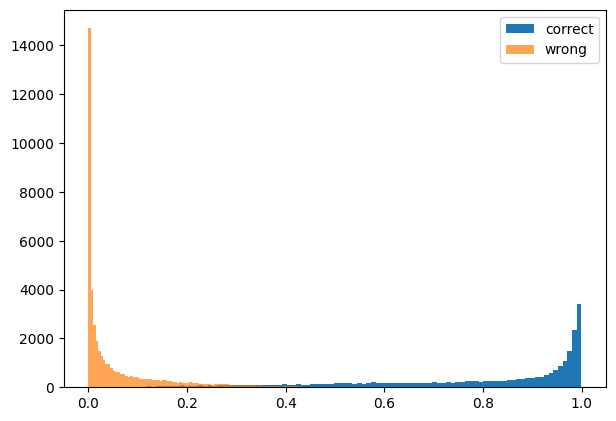

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(x, bins=100, label='correct')
plt.hist(y, bins=100, label='wrong', alpha=0.7)
plt.legend()
print()

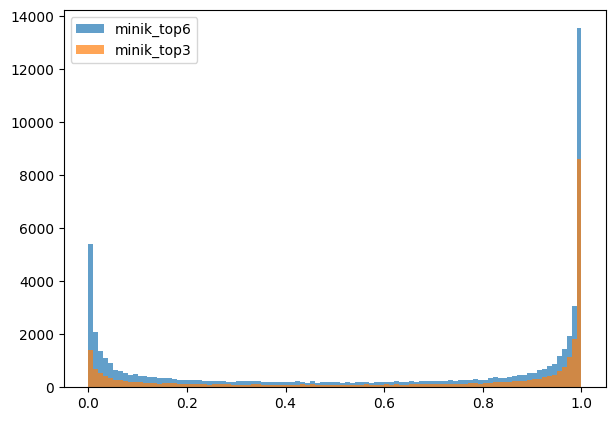

In [175]:
plt.close()
plt.hist(minik_top6, bins=100, label='minik_top6', alpha = 0.7)
plt.hist(minik_top3, bins=100, label='minik_top3', alpha = 0.7)
plt.legend()
plt.show()

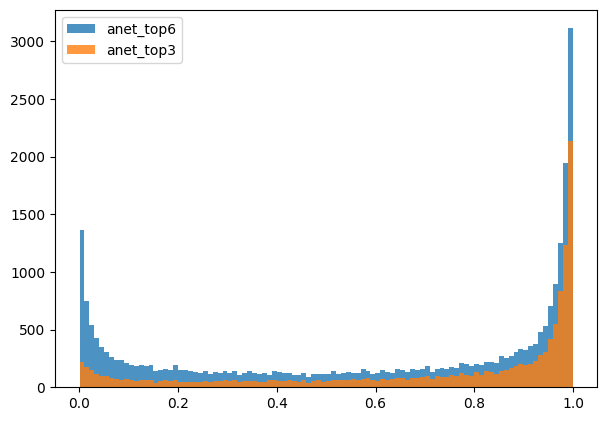

In [174]:
plt.close()
plt.hist(anet_top6, bins=100, label='anet_top6', alpha = 0.8)
plt.hist(anet_top3, bins=100, label='anet_top3', alpha = 0.8)
plt.legend()
plt.show()

In [98]:
import numpy as np
a = np.asarray(results)
b = np.asarray(sampled_indice)

In [99]:
torch.save(a, './tensors/minik_u10to1_logit_s_result.pt')
torch.save(b, './tensors/minik_u10to1_logit_s_indice.pt')

In [2]:
idataloader = iter(data_loader)

In [3]:
data = next(idataloader)
# imgs, labels = data['imgs'], data['label'].squeeze()

In [4]:
from einops import rearrange
perm_num = 6
with torch.no_grad():
    imgs, labels = data['imgs'], data['label'].squeeze()
    imgs, labels = imgs.cuda(), labels.cuda()
    B, N, C, T, H, W = imgs.shape
    imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
    # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
    x = model.extract_feat(imgs.unsqueeze(2))
    logits = model.cls_head(x) # B*T num_classes
    logits = logits.softmax(-1)
    logits = logits.reshape(B, T, -1)
    label_logits = logits[range(B), :, labels.squeeze()]

    max_idx = label_logits.topk(1, dim=1)[1].sort(dim=1,descending=False)[0]
    batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
    imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b=B, t=T)
    sampled_imgs = imgs[batch_inds, max_idx]
    sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')
    fx = model.extract_feat(sampled_imgs)
    flogits = model.cls_head(fx)
    result = flogits.detach().cpu().numpy()

In [29]:
imgs, labels = data['imgs'].cuda(), data['label'].cuda()
with torch.no_grad():
    B, N, C, T, H, W = imgs.shape
    imgs = rearrange(imgs, 'b n c t h w -> (b n t) c h w')
    # imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
    x = model.extract_feat(imgs.unsqueeze(2))
    logits = model.cls_head(x) # B*T num_classes
    # logits = logits.softmax(-1)
    negative_entropy = (logits * torch.log(logits)).sum(-1)
    negative_entropy = negative_entropy.reshape(B, T)
    max_idx = negative_entropy.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
    batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
    imgs = rearrange(imgs, '(b t) c h w -> b t c h w', b=B, t=T)
    sampled_imgs = imgs[batch_inds, max_idx]
    sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')

    fx = model.extract_feat(sampled_imgs)
    flogits = model.cls_head(fx)
    result = flogits.detach().cpu().numpy()


In [32]:
torch.tensor( [7.64,  6.15,  2.12, -1.02]).softmax(-1)

tensor([8.1330e-01, 1.8330e-01, 3.2580e-03, 1.4101e-04])

In [17]:
import numpy as np
np.log(1/200)

-5.298317366548036

In [14]:
-(logits[0] * torch.log(logits[0])).sum(-1)

tensor(2.4935, device='cuda:0')

In [24]:
negative_entropy[-5]

tensor([-1.4538, -2.5542, -2.0615, -1.9998, -2.0039, -4.1134, -4.1134, -4.1134,
        -4.1134, -4.1134], device='cuda:0')

In [25]:
label_logits[-5]

tensor([0.0801, 0.1262, 0.0321, 0.0498, 0.0791, 0.0282, 0.0282, 0.0282, 0.0282,
        0.0282], device='cuda:0')

In [52]:
imgs, labels = data['imgs'], data['label'].squeeze()

In [53]:
imgs = imgs.reshape(50, 3, 10, 224, 224)

In [55]:
imgs = imgs.transpose(1,2)

In [36]:
imgs.shape

torch.Size([50, 10, 3, 224, 224])

In [136]:
sampled_imgs[0].shape

torch.Size([3, 1, 224, 224])

In [44]:
imgs[0].shape

torch.Size([10, 3, 224, 224])

In [18]:
sampled_imgs = perm_imgs

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms.functional import to_pil_image

idx = torch.randint(0,50,[1,])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor=tensor.clone()
        f, c, h, w = tensor.shape
        for img in tensor:
            for t, m, s in zip(img, self.mean, self.std):
                t.mul_(s).add_(m)
                # The normalize code -> t.sub_(m).div_(s)
        return tensor

    def show(imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(nrows=len(imgs), squeeze=False, figsize=(40,14))
        # plt.suptitle(f'Label - {label_map[label]}, Path - {path}',fontsize=20)
        fix.tight_layout()
        for i, img in enumerate(imgs):
            img = img.detach()
            img = to_pil_image(img)
            axs[i, 0].imshow(np.asarray(img))
            axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
unorm = UnNormalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375])
u_imgs = unorm(imgs[idx][0])
u_sampled_imgs = unorm(sampled_imgs[idx].transpose(1,2)[0])
grid = [make_grid(u_imgs.to(torch.uint8), 10), make_grid(u_sampled_imgs.to(torch.uint8), 2)]
show(grid)

ValueError: too many values to unpack (expected 4)

In [10]:
label_logits[0]

tensor([ 1.5257, -0.3109,  0.1788, -0.7290, -1.1499, -1.2177,  0.2845, -0.2046,
         3.6867,  0.4259], device='cuda:0')

In [15]:
imgs.shape

torch.Size([50, 10, 3, 224, 224])

In [17]:
imgs[0][[0,2,6,7,8,9]].shape

torch.Size([6, 3, 224, 224])

In [24]:
max_idx[0]

tensor([0, 2, 6, 7, 8, 9], device='cuda:0')

In [ ]:
a=imgs[0][[0,2,6,7,8,9]]
b=sampled_imgs[0]

In [ ]:
imgs = imgs.reshape(B * T, C, H, W) # B*T C H W
x = model.extract_feat(imgs.unsqueeze(2))
logits = model.cls_head(x) # B*T num_classes
logits = logits.reshape(B, T, -1)
label_logits = logits[range(B), :, labels.squeeze()]

# max_idx = label_logits.topk(1, dim=1)[1].sort(dim=1,descending=False)[0]
# batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
# result = logits[batch_inds, max_idx].squeeze()

max_idx = label_logits.max(-1)[1]
result = logits[range(B), max_idx, :]

result = result.detach().cpu().numpy()

In [2]:
idataloader = iter(data_loader)

In [3]:
data = next(idataloader)
# imgs, labels = data['imgs'], data['label'].squeeze()

In [55]:
total_seg = 10
perm_num = 2
perms = list(combinations([i for i in range(total_seg)],perm_num))
model.eval()
with torch.no_grad():
    imgs, labels = data['imgs'], data['label'].squeeze()
    imgs, labels = imgs.cuda(), labels.cuda()
    B, N, C, T, H, W = imgs.shape
    perm_imgs = []
    score = torch.zeros([B, total_seg]).cuda()
    for perm in perms:
        indice = torch.tensor([1 if i in perm else 0 for i in range(total_seg)]).bool()
        perm_imgs.append(imgs[:,:,:,indice])
    perm_imgs = torch.stack(perm_imgs, 1)
    perm_imgs = rearrange(perm_imgs, 'b p n c t h w -> (b p n) c t h w')
    x = model.extract_feat(perm_imgs)
    logits = model.cls_head(x) # B*len(perms) num_classes
    logits = rearrange(logits, '(b p) n -> b p n', b = B, p = len(perms)) # B len(perms) num_classes
    label_logits = logits[range(B), :, labels.squeeze()]
    total_score = label_logits.mean(-1)
    for i in range(total_seg):
        tmp = torch.zeros_like(total_score)
        for j in range(len(perms)):
            if i in perms[j]:
                tmp += label_logits[:, j]
        score[:, i] = total_score - tmp/9
    max_idx = score.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
    batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
    imgs = rearrange(imgs, 'b n c t h w -> (b n) t c h w')
    sampled_imgs = imgs[batch_inds, max_idx]
    sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')
    fx = model.extract_feat(sampled_imgs)
    flogits = model.cls_head(fx)
    result = flogits.detach().cpu().numpy()

In [23]:
label_logits[:, 0]

tensor([10.8736,  7.4793,  8.0049, 15.2361,  6.2707, 11.8610,  9.4330,  4.9589,
         8.0566,  8.2250,  6.4955,  9.3159,  7.6948,  6.3771,  9.8631,  7.9948,
         4.9741,  9.3425,  2.7163,  8.2024,  9.5474,  6.4704,  5.7176,  8.1301,
         9.9383, 10.6796,  7.1633, 13.5326,  8.5640,  5.2459], device='cuda:0')

In [24]:
score[0]

tensor([ 0.1558, -0.1787, -0.0931, -0.0742, -2.2390,  0.8747, -0.6735, -0.3846,
         0.7825,  1.8301], device='cuda:0')

In [9]:
total_score[0]

tensor(501.4761, device='cuda:0')

In [12]:
label_logits[0]

tensor([10.8736, 11.0055,  9.7906, 13.9045, 10.5663, 12.1575, 12.1909,  9.7229,
         8.6814, 11.1525, 12.1052, 12.8016, 10.3786, 12.4423, 11.3939, 10.1923,
        10.5636, 11.0809, 14.0698, 10.6421, 12.2827, 11.3482, 10.3151,  9.2359,
        14.1013, 10.9181, 12.0799, 11.4991, 10.1141,  9.2743, 12.1695, 14.9192,
        14.7238, 12.9157, 10.8409,  9.5833, 10.3983,  9.5909,  8.1758, 12.2316,
        11.2830,  9.3769, 10.7069,  9.2638,  8.4117], device='cuda:0')

In [5]:
result

array([[13.525547  ,  4.232628  ,  4.33488   , ..., -1.4578041 ,
         1.1844931 ,  0.83911103],
       [10.21198   ,  3.0332232 ,  3.4635575 , ..., -2.4009047 ,
         4.6497517 ,  3.302033  ],
       [ 9.506054  ,  0.9489721 ,  3.6970081 , ..., -2.774393  ,
         3.4367907 , -2.002809  ],
       ...,
       [15.286939  ,  2.4639966 ,  3.686197  , ..., -1.7040263 ,
         1.0236428 ,  1.0594429 ],
       [ 9.659581  ,  3.1600344 ,  2.4629824 , ..., -2.1093814 ,
         1.8079818 , -1.3402663 ],
       [ 7.805283  ,  0.58568823,  4.3149834 , ..., -2.693321  ,
         4.7270737 , -2.8046846 ]], dtype=float32)

In [6]:
total_seg = 10
perm_num = 2
perms = list(combinations([i for i in range(total_seg)],perm_num))
model.eval()
with torch.no_grad():
    imgs, labels = data['imgs'], data['label'].squeeze()
    imgs, labels = imgs.cuda(), labels.cuda()
    B, N, C, T, H, W = imgs.shape
    perm_imgs = []
    score = torch.zeros([B, total_seg]).cuda()
    for perm in perms:
        indice = torch.tensor([1 if i in perm else 0 for i in range(total_seg)]).bool()
        perm_imgs.append(imgs[:,:,:,indice])
    perm_imgs = torch.stack(perm_imgs, 0)
    perm_imgs = rearrange(perm_imgs, 'p b n c t h w -> (p b n) c t h w')
    x = model.extract_feat(perm_imgs)
    logits = model.cls_head(x) # B*len(perms) num_classes
    logits = rearrange(logits, '(b p) n -> b p n', b = B, p = len(perms)) # B len(perms) num_classes
    label_logits = logits[range(B), :, labels.squeeze()]
    for i in range(len(perms)):
        for j in range(len(perms[i])):
            score[:, perms[i][j]] += label_logits[:, i]
    max_idx = score.topk(6, dim=1)[1].sort(dim=1,descending=False)[0]
    batch_inds = torch.arange(B).unsqueeze(-1).expand_as(max_idx)
    imgs = rearrange(imgs, 'b n c t h w -> (b n) t c h w')
    sampled_imgs = imgs[batch_inds, max_idx]
    sampled_imgs = rearrange(sampled_imgs, 'b t c h w -> b c t h w')
    fx = model.extract_feat(sampled_imgs)
    flogits = model.cls_head(fx)
    result = flogits.detach().cpu().numpy()

In [7]:
result

array([[14.544764  ,  3.6215591 ,  2.983023  , ..., -1.4017637 ,
         1.1687435 ,  0.04351258],
       [ 8.651378  ,  3.79117   ,  2.1004863 , ..., -1.9918274 ,
         4.472507  ,  1.4226387 ],
       [ 9.058618  ,  1.2275242 ,  4.017436  , ..., -3.0507202 ,
         3.2552104 , -1.4165667 ],
       ...,
       [ 9.602396  ,  1.543493  ,  2.7375624 , ...,  1.0918307 ,
         3.256653  , -4.211716  ],
       [-0.31665733,  0.25631097,  0.19727069, ..., -1.2034167 ,
         4.004699  ,  1.7919914 ],
       [ 7.5830936 , -0.1668594 ,  4.1315694 , ..., -2.8547604 ,
        -0.32634628, -3.6885107 ]], dtype=float32)